## Loading Packages and Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_venn import venn2
from load_utils import *
from analysis_utils import *

After loading the algorithmically scored data, we choose a threshold of the score at which point we will consider a revision an attack. Here, we choose a threshold of 0.7 in order to avoid having too many false positives. We then group the revisions by both the user writing the revision (df_a) and the recipient of the revision (df_v)

In [2]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

In [6]:
d['2015']['pred_recipient'] = (d['2015']['pred_recipient_score'] > 0.7)

In [7]:
df_a = d['2015'].groupby('user_text', as_index = False).agg({'pred_recipient': ['count','sum'], 
                                                             'user_id': 'first', 'author_anon': 'first'})
df_v = d['2015'].query('ns == "user"').groupby('page_title', as_index = False).agg({'pred_recipient': ['count','sum'], 
                                                                                    'recipient_anon': 'first'})

In [8]:
df_a.columns = ['user_text', 'author_anon', 'total', 'attacks', 'user_id']
df_v.columns = ['user_text', 'recipient_anon', 'total_rec', 'attacks_rec']

In [9]:
df_av = pd.merge(df_a, df_v, on = 'user_text', how = 'inner')

## The Attack Fraction

We compute the fraction of each user's revisions that are classified as attacks

In [10]:
df_a['frac_attacks'] = df_a['attacks']/df_a['total']

We plot the histogram of attack fractions below.

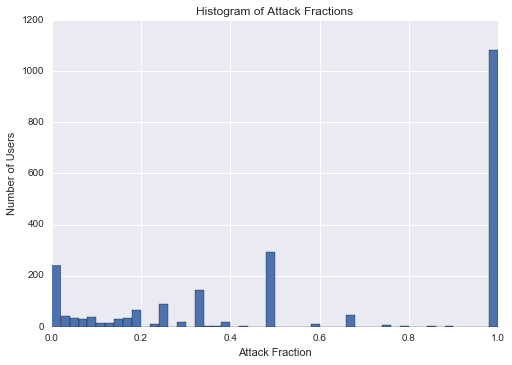

In [11]:
hist = df_a.query('attacks > 0')['frac_attacks'].hist(bins = 50)
hist.set_title('Histogram of Attack Fractions')
hist.set_xlabel('Attack Fraction')
hist.set_ylabel('Number of Users')

In [12]:
df_a.groupby('author_anon', as_index = False).agg({'frac_attacks': ['mean', 'std']})

author_anon frac_attacks          
                      mean       std
0       False     0.004368  0.060506
1        True     0.008599  0.087084

## Studying Trolls

We define a troll to be an editor whose comments are at least 50% attacks. 

In [13]:
troll_threshold = 0.5

In [14]:
df_a['is_troll'] = df_a['frac_attacks'] > troll_threshold

By this definition, half of all attacks that occured in 2015 were made by trolls.

In [15]:
troll_agg = df_a.groupby('is_troll').agg({'attacks':'sum', 'total': 'mean'})
troll_agg

,attacks,total
is_troll,,
False,1483,8.947543
True,1525,1.404310


We also plot a cumulative histogram of users by attack fraction.

In [16]:
values, base = np.histogram(df_a[['frac_attacks']], bins = 10000)

In [17]:
cumulative = 100.0*np.cumsum(values)/np.sum(values)

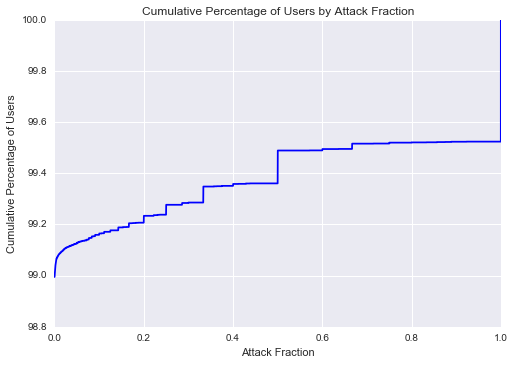

In [18]:
plt.plot(base[:-1], cumulative, c='blue')

plt.xlabel('Attack Fraction')
plt.ylabel('Cumulative Percentage of Users')
plt.title('Cumulative Percentage of Users by Attack Fraction')

From this histogram we see, for example, that:
- 0.65% of users have a 100% fraction of attacks (45% of attacking users).
- 98.5% of users have 0 attacks.

We also plot a cumulative histogram of the total number of attacks by user's attack fraction. That is, this histogram plots the percentage of the total number of attacks that are caused by users with an attack fraction at most 'x'.

In [19]:
values, base = np.histogram(df_a[['frac_attacks']], weights = df_a[['attacks']], bins = 10000)

In [20]:
cumulative = 100.0*np.cumsum(values)/np.sum(values)

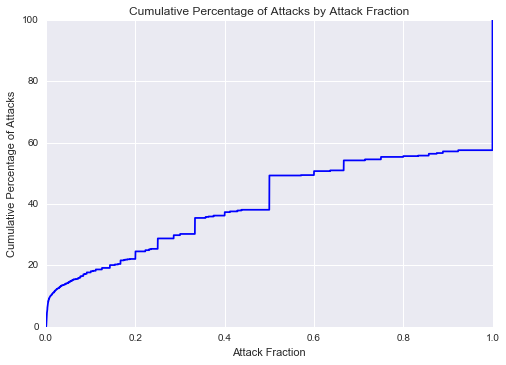

In [21]:
plt.plot(base[:-1], cumulative, c='blue')

plt.xlabel('Attack Fraction')
plt.ylabel('Cumulative Percentage of Attacks')
plt.title('Cumulative Percentage of Attacks by Attack Fraction')

From this histogram, we see that around 38% of attacks come from people who are "complete trolls" (100% of their comments are attacks).

## Low Activity Users

We analyze the number of attacks by accounts with few total posts. These could represent sockpuppet accounts. Below we plot the cumulative percentage of attacks covered by users with a certain number of total revisions.

In [37]:
values, base = np.histogram(df_a[['total']], weights = df_a[['attacks']], bins = 10000)

In [38]:
cumulative = 100.0*np.cumsum(values)

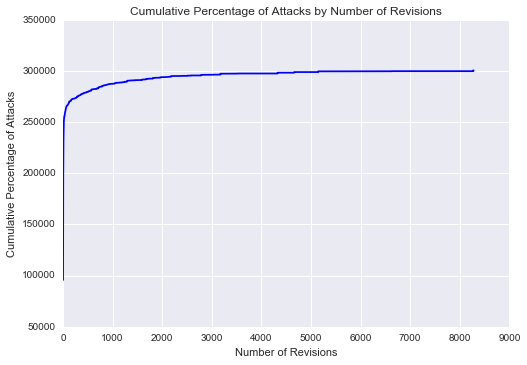

In [39]:
plt.plot(base[:-1], cumulative, c='blue')
plt.xlabel('Number of Revisions')
plt.ylabel('Cumulative Percentage of Attacks')
plt.title('Cumulative Percentage of Attacks by Number of Revisions')

From this histogram we see that:
- 26.69% of all attacks come from users that have only made 1 revision
- This jumps goes to 38.7%, 46.0%, 50.6% for 2, 3, 4 total revisions
- The big jump we see is the result of one big troll

In [40]:
df_a.query('total <= 707').query('total >= 706')

,user_text,author_anon,total,attacks,user_id,frac_attacks,is_troll
174542,Missionedit,False,707,3,17863160,0.004243,False


... want to analyze the small accounts by anonymity..

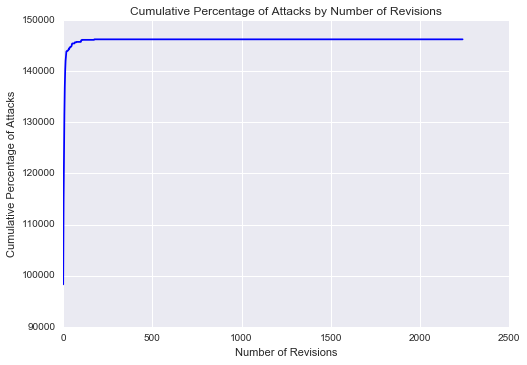

In [41]:
df = df_a.query('author_anon == True')
values, base = np.histogram(df[['total']], weights = df[['attacks']], bins = 1000)
cumulative = 100.0*np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.xlabel('Number of Revisions')
plt.ylabel('Cumulative Percentage of Attacks')
plt.title('Cumulative Percentage of Attacks by Number of Revisions')

In [42]:
cumulative[0:10]

array([  98300.,  114500.,  123900.,  131500.,  136800.,  140100.,
        142000.,  142900.,  143800.,  143900.])

In [43]:
base[0:10]

array([  1.   ,   3.239,   5.478,   7.717,   9.956,  12.195,  14.434,
        16.673,  18.912,  21.151])

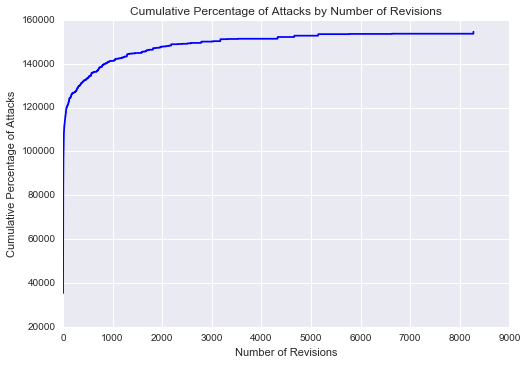

In [44]:
df = df_a.query('author_anon == False')
values, base = np.histogram(df[['total']], weights = df[['attacks']], bins = 10000)
cumulative = 100.0*np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.xlabel('Number of Revisions')
plt.ylabel('Cumulative Percentage of Attacks')
plt.title('Cumulative Percentage of Attacks by Number of Revisions')

In [52]:
cumulative[50:100]

array([ 115100.,  115200.,  115200.,  115300.,  115600.,  115800.,
        115900.,  115900.,  116100.,  116400.,  116500.,  116800.,
        116900.,  116900.,  117100.,  117200.,  117400.,  117400.,
        117800.,  117800.,  117800.,  118600.,  118600.,  118600.,
        118700.,  118700.,  119000.,  119300.,  119400.,  119400.,
        119500.,  119500.,  119600.,  119600.,  119900.,  120000.,
        120000.,  120000.,  120100.,  120300.,  120300.,  120300.,
        120300.,  120300.,  120300.,  120300.,  120300.,  120400.,
        120400.,  120400.])

In [53]:
base[50:100]

array([ 42.375 ,  43.2025,  44.03  ,  44.8575,  45.685 ,  46.5125,
        47.34  ,  48.1675,  48.995 ,  49.8225,  50.65  ,  51.4775,
        52.305 ,  53.1325,  53.96  ,  54.7875,  55.615 ,  56.4425,
        57.27  ,  58.0975,  58.925 ,  59.7525,  60.58  ,  61.4075,
        62.235 ,  63.0625,  63.89  ,  64.7175,  65.545 ,  66.3725,
        67.2   ,  68.0275,  68.855 ,  69.6825,  70.51  ,  71.3375,
        72.165 ,  72.9925,  73.82  ,  74.6475,  75.475 ,  76.3025,
        77.13  ,  77.9575,  78.785 ,  79.6125,  80.44  ,  81.2675,
        82.095 ,  82.9225])

In [63]:
values, base = np.histogram(df_a[['total']], weights = df_a[['attacks']], bins = [0,5,10,25,50,100,200,500,1000,2000,10000])


In [66]:
base

array([    0,     5,    10,    25,    50,   100,   200,   500,  1000,
        2000, 10000])

In [67]:
values

array([ 1840.,   438.,   267.,    65.,    60.,    58.,    70.,    77.,
          65.,    68.])

In [68]:
x = range(len(values))

In [69]:
width = 1/1.5

<Container object of 10 artists>

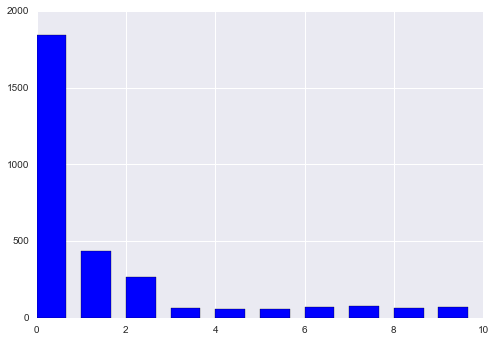

In [70]:
plt.bar(x, values, width, color="blue")

## What proportion of troll accounts have ever been blocked

Here we look at the intersection of blocked users and trolls

In [22]:
Blocked = set(df_events['user_text'])
Blocked_2015 = set(df_events.query('year == 2015')['user_text'])
Trolls = set(df_a.query('frac_attacks > 0.5')['user_text'])

In [23]:
print '# Blocked Users: %s' % len(Blocked)
print '# Blocked Users (2015): %s' % len(Blocked_2015)
print '# Trolls: %s' % len(Trolls)
print '# Trolls that were Blocked: %s' % len(Blocked.intersection(Trolls))
print '# Trolls that were Blocked in 2015: %s' % len(Blocked_2015.intersection(Trolls))

# Blocked Users: 23668
# Blocked Users (2015): 1250
# Trolls: 1623
# Trolls that were Blocked: 101
# Trolls that were Blocked in 2015: 98


<matplotlib_venn._common.VennDiagram instance at 0x122de4b48>

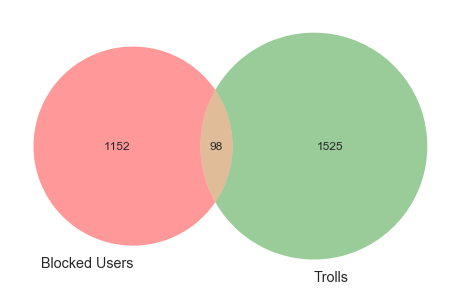

In [52]:
only_blocked_users = len(Blocked_2015) - len(Blocked_2015.intersection(Trolls))
only_trolls = len(Trolls) - len(Blocked_2015.intersection(Trolls))
blocked_and_trolls = len(Blocked_2015.intersection(Trolls))
venn2(subsets = (only_blocked_users, only_trolls, blocked_and_trolls), 
      set_labels = ('Blocked Users', 'Trolls'))

We could also analyze how many blocked users are considered attacking by our algorithm. Below we see that 287 out of the 1250 blocked users are detected by attacking by our algorithm. It is worth exploring why the other users were blocked.

In [24]:
print len(Blocked_2015.intersection(df_a.query('attacks > 0')['user_text']))

287


In [25]:
len(df_a.query('attacks > 0')['user_text'])

3398

## The Attacks Received Fraction

Analgously to the attack fraction, we also analyze victims by the fraction of the revisions on their talk pages that were attacks. **IMPORTANT CAVEAT**: This does not capture the total number of attacks on a user as many (often most) attacks would happen on other talk pages.

In [26]:
df_v.columns = ['user_text', 'recipient_anon', 'total_rec', 'attacks_rec']

We plot the histogram below.

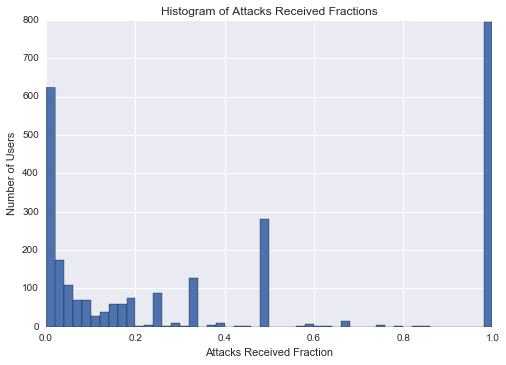

In [27]:
df_v['frac_attacks_rec'] = df_v['attacks_rec']/df_v['total_rec']
hist = df_v.query('attacks_rec > 0')['frac_attacks_rec'].hist(bins = 50)
hist.set_title('Histogram of Attacks Received Fractions')
hist.set_xlabel('Attacks Received Fraction')
hist.set_ylabel('Number of Users')

## Low Activity User Talk Pages

We analyze the number of attacks received by talk pages with few total posts. Below we plot the cumulative percentage of attacks received by user talk pages with a certain number of total revisions received.

In [39]:
values, base = np.histogram(df_v[['total_rec']], weights = df_v[['attacks_rec']], bins = 10000)

In [40]:
cumulative = 100.0*np.cumsum(values)/np.sum(values)

In [50]:
print 'Total number of attacks received on user talk pages: %s' % np.sum(values)

Total number of attacks received on user talk pages: 4218


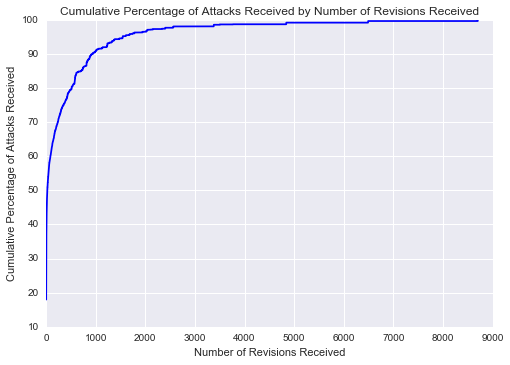

In [41]:
plt.plot(base[:-1], cumulative, c='blue')
plt.xlabel('Number of Revisions Received')
plt.ylabel('Cumulative Percentage of Attacks Received')
plt.title('Cumulative Percentage of Attacks Received by Number of Revisions Received')

## Gender Analysis

We also compute the average attack fraction and attack received fraction by gender.

In [28]:
df_a = get_author_genders(df_a)

In [29]:
df_a.groupby('author_gender', as_index = False).agg({'frac_attacks': ['mean', 'std']})

author_gender frac_attacks          
                               mean       std
0               female     0.002469  0.043714
1                 male     0.001246  0.029004
2  unknown: registered     0.006851  0.075850
3         unknown:anon     0.012019  0.102701

In [30]:
df_v['page_title'] = df_v['user_text']

In [31]:
df_v = get_recipient_genders(df_v)

In [32]:
df_v.groupby('recipient_gender', as_index = False).agg({'frac_attacks_rec': ['mean', 'std']})

recipient_gender frac_attacks_rec          
                                   mean       std
0               female         0.009331  0.084713
1                 male         0.005241  0.056950
2  unknown: registered         0.005379  0.066119
3         unknown:anon         0.012286  0.103478

We see that both the attack fraction and attacks received fraction are higher for females than males. These numbers should be correlated as attacks usually occur on a single talk page, rather than back and forth between the attacker and the recipient. These high numbers might be best explained by the fact that female editors are attacked and defend themselves via attacking comments.

## Joint Analysis of Victims and Attackers

We first compute the overlap between attackers and victims. We discover that a third of attackers are also victims and almost a half of victims are attackers.

In [33]:
Attackers = set(df_a.query('attacks > 0')['user_text'])
Victims = set(df_v.query('attacks_rec > 0')['user_text'])

In [34]:
print '# Attackers: %s' % len(Attackers)
print '# Victims: %s' % len(Victims)
print '# Both: %s' % len(Attackers.intersection(Victims))

# Attackers: 3398
# Victims: 2667
# Both: 1222


<matplotlib_venn._common.VennDiagram instance at 0x138795368>

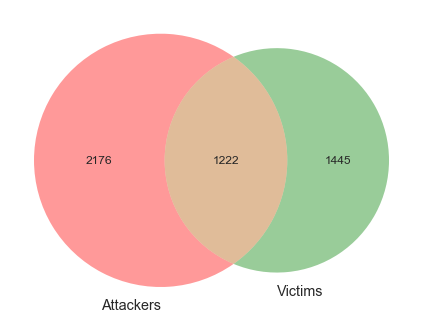

In [35]:
only_attackers = len(Attackers) - len(Attackers.intersection(Victims))
only_victims = len(Victims) - len(Attackers.intersection(Victims))
attackers_and_victims = len(Attackers.intersection(Victims))
venn2(subsets = (only_attackers, only_victims, attackers_and_victims), 
      set_labels = ('Attackers', 'Victims'))

We define a user to be a saint if they have received more attacks than they have made. Again, it is important to remember that we can only count attacks received on a user's own talk page. This does not capture a large proportion of attacks a user might receive.

In [36]:
df_av['is_saint'] = ((df_av['attacks_rec'] - df_av['attacks']) > 0)

We show below that there are very few users that are saints. Again, this analysis is misleading due to the caveat above.

In [37]:
df_av.groupby('is_saint', as_index = False).agg({'user_text': 'count'})

,is_saint,user_text
0,False,77717
1,True,1120
